# ニューラルネットワーク (2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

前章では、多層のニューラルネットワークを一般的に表現する方法を説明した。また、論理和（OR）や論理積（AND）などの論理結合子に対応する単層ニューラルネットワーク（線形分類器）のパラメータを学習で求め、その組み合わせで排他的論理和（XOR）の入出力を再現する多層ニューラルネットワークを構成する例を示した。排他的論理和の例では、入力と出力の組み合わせの数が少ないうえ、入力を出力に対応付ける背景知識（論理）が明確であった。ところが、機械学習が用いられるシナリオは、入力を出力に対応づけるメカニズムが不明な状況において、訓練データのみを用いて入力から出力を計算する写像を獲得することである。単層ニューラルネットワークの学習方法は回帰や線形分類などで説明した通りであるが、多層ニューラルネットワークの学習はどのようにすれば良いのだろうか？

本章では、ニューラルネットワークのモデルのパラメータを確率的勾配降下法で汎用的に学習する手法として、**計算グラフ**（computation graph）による**自動微分**（automatic differentiation）を紹介する。その後、[PyTorch](https://pytorch.org/)による実装を紹介する。

まず、確率的勾配降下法の更新式を思い出してみたい。モデルに含まれる全てのパラメータを1次元に並べてベクトルとして一般的に表現したものを$\pmb{\theta}$と書くことにする。例えば、式[(7.24)](#f7-24)の例では、行列$\pmb{W}^{(1)}, \pmb{W}^{(2)}$の全ての要素、ベクトル$\pmb{b}^{(1)}$の全ての要素、スカラー$b^{(2)}$を並べたベクトルが$\pmb{\theta}$である。ある訓練事例$(\pmb{x}, \pmb{y})$に対する損失関数を$\hat{l}_{\pmb{x}, \pmb{y}}(\pmb{\theta}^{(t)})$と定義する。$t$回目の反復時のパラメータの値を$\pmb{\theta}^{(t)}$と書くことにすると、パラメータの更新式は、

<a id="f8-1"></a>
(8.1)  
\begin{align}
\pmb{\theta}^{(t+1)} = \pmb{\theta}^{(t)} - \eta_t \nabla \hat{l}_{\pmb{x}, \pmb{y}}(\pmb{\theta}^{(t)})
\end{align}

パラメータベクトル$\pmb{\theta}$の要素数を$K$とすると、勾配$\nabla \hat{l}_{\pmb{x}, \pmb{y}}(\pmb{\theta})$は、

<a id="f8-2"></a>
(8.2)  
\begin{align}
\nabla \hat{l}_{\pmb{x}, \pmb{y}}(\pmb{\theta}) = \begin{pmatrix} \frac{\partial \hat{l}_{\pmb{x}, \pmb{y}}(\pmb{\theta})}{\partial \theta_1} & \frac{\partial \hat{l}_{\pmb{x}, \pmb{y}}(\pmb{\theta})}{\partial \theta_2} & \dots & \frac{\partial \hat{l}_{\pmb{x}, \pmb{y}}(\pmb{\theta})}{\partial \theta_K} \end{pmatrix}
\end{align}

である。ゆえに、損失関数$\hat{l}_{\pmb{x}, \pmb{y}}(\pmb{\theta})$に対して、全てのパラメータ$\theta_k$ ($k \in \{1, 2, \dots, K\}$) に関する偏微分を求めることができれば、確率的勾配降下法を適用できる。これまでは、損失関数の定義から合成関数の微分や連鎖律を駆使して偏微分を求め、回帰では式[(4.32)](#f4-32)、線形二値分類では式[(5.31)](#f5-31)、線形多値分類では式[(6.33)](#f6-33)を得た。しかし、多層ニューラルネットワークになると損失値を計算するまでに関数の合成が何回も繰り返されるため、偏微分を手作業で求めるのは大変である。また、用いるニューラルネットワークの形状や活性化関数によって偏微分を求める式が変わってしまうため、全ての場合に対して手作業で偏微分を求めるのは現実的ではない。そこで、ニューラルネットワークの学習では損失関数を計算グラフとして表現し、自動微分で偏微分を求めるのが定石となっている。これは、ニューラルネットワークの学習方法として考案された**誤差逆伝播法**（backpropagation）と本質的に同じものである。  


---

【補足】誤差逆伝播法 とは  
ニューラルネットワークで算出した 予測値 と 正解 の誤差を元に、各層の重みを修正  
出力層→入力層(逆方向)へ修正する  


---


## 計算グラフと自動微分

**計算グラフ**（computation graph）は、計算式の中にある変数や定数を葉ノード、計算を行う順番に沿って演算子を内部ノードとして配置し、ボトムアップに計算を行うことで、全体の計算結果を根ノードで得られるようにした木構造である。このように説明すると難しそうであるが、例を見れば単純明快である。

### 前向き計算

以下に$y=ax+b$の計算グラフを示した。ここで、$(a, b) = (-2, 4), x = 3$であるとき、$y$を計算するには計算グラフの葉からボトムアップに演算子（内部ノード）を適用し、途中の計算結果を保持しながら根ノード$y$まで計算を進めればよい。以下の図では、この計算過程をアニメーションで見ることができる。このアニメーションでは葉が左側、根が右側に配置されているため、左から右に向かって計算が進む。この計算過程を**前向き計算**（forward computation）と呼ぶ。

In [2]:
def find_renderer(fig):
    if hasattr(fig.canvas, "get_renderer"):
        renderer = fig.canvas.get_renderer()
    else:
        import io
        fig.canvas.print_pdf(io.BytesIO())
        renderer = fig._cachedRenderer
    return renderer

def draw_variable(ax, x, y, s, requires_grad=False):
    bbox = bbox=dict(boxstyle='circle', fill=False, linewidth=0.5) if requires_grad else None
    return ax.text(x, y, s, bbox=bbox, ha='center', va='center', fontsize=config['variable-font-size'])
    
def draw_operator(ax, x, y, s):
    return ax.text(x, y, s, bbox=dict(boxstyle='square', fill=False, linewidth=0.5), ha='center', va='center', fontsize=config['operator-font-size'])

def draw_arrow(ax, x0, x1, y0, y1, style='arrow'):
    cstyle = 'arc3'
    if style == 'below':
        cstyle = 'angle,angleA=0,angleB=90,rad=0.0'
    elif style == 'above':
        cstyle = 'angle,angleA=0,angleB=-90,rad=0.0'        
    ax.annotate(
        "",
        xy=(x1, y1), xycoords='data',
        xytext=(x0, y0), textcoords='data',
        arrowprops=dict(arrowstyle="-|>,head_length=0.2,head_width=0.1", connectionstyle=cstyle, facecolor='black', linewidth=0.5),
        )

def write_message(msg):
    A = []
    p = msg.find(r' \\ ')
    if p != -1:
        msg1 = msg[:p]
        msg2 = msg[p+4:]
        A.append(ax.text(config['message-x'], config['message-y'], msg1, ha='center', va='center', fontsize=config['message-font-size']))
        A.append(ax.text(config['message-x'], config['message-y']-0.5, msg2, ha='center', va='center', fontsize=config['message-font-size']))
    else:
        A.append(ax.text(config['message-x'], config['message-y'], msg, ha='center', va='center', fontsize=config['message-font-size']))
    return A

def write_value(x, y, v, name, updated=False, backward=False):
    A = []
    c = 'tab:red' if updated else ('tab:blue' if backward else 'tab:gray')
    if name is not None:
        A.append(ax.text(x, y+0.2, name, ha='center', va='center', fontsize=config['value-font-size'], color=c))
    A.append(ax.text(x, y, v, ha='center', va='center', fontsize=config['value-font-size'], color=c))
    return A

def forward(ax, S, t):    
    artists = []
    backward = False
    for i in range(1, t+1):
        s = S[i-1]
        if s is None or len(s) < 4:
            continue
        if s[0] == 'Backward pass':
            backward = True
        name = s[4] if len(s) >= 5 else None
        artists += write_value(s[1], s[2], s[3], name, t==i, backward)
            
    s = S[t-1]
    if s is not None:
        artists += write_message(s[0])
    
    return artists

config = {
    'variable-font-size': 10,
    'operator-font-size': 8,
    'message-font-size': 10,
    'value-font-size': 10,
    'message-x': 3,
    'message-y': 1,
}

def draw_computation_graph(ax):
    draw_variable(ax, 1, 4, '$a$', requires_grad=True)
    draw_variable(ax, 0.5, 4, '$-2$')
    draw_variable(ax, 1, 3, '$x$', requires_grad=True)
    draw_variable(ax, 0.5, 3, '$3$')
    draw_variable(ax, 1, 2, '$b$', requires_grad=True)
    draw_variable(ax, 0.5, 2, '$4$')
    draw_variable(ax, 3.3, 4, r'$\alpha = ax$')
    draw_variable(ax, 5.5, 2.7, r'$y$')
    draw_operator(ax, 2.5, 3.5, r'$\times$')
    draw_operator(ax, 4, 2.7, '$+$')
    draw_arrow(ax, 1.15, 2.5, 3, 3.4, 'below')
    draw_arrow(ax, 1.15, 2.5, 4, 3.6, 'above')
    draw_arrow(ax, 1.15, 4, 2, 2.6, 'below')
    draw_arrow(ax, 2.6, 4, 3.5, 2.8, 'above')
    draw_arrow(ax, 4.1, 5.4, 2.7, 2.7)

S = [
    [r'Forward pass'],
    [r'$a \cdot x = (-2) \times 3 = -6$', 3.3, 3.7, r'-6'],
    [r'$ax + b = -6 + 4 = -2$', 4.7, 2.9, '-2'],
    None,
    [r'Backward pass', 4.7, 2.4, '1'],
    [r'$y = \alpha + b$, $\frac{\partial y}{\partial \alpha} = 1$', 3.3, 3.2, r'$\frac{\partial y}{\partial \alpha} = 1$'],
    [r'$y = \alpha + b$, $\frac{\partial y}{\partial b} = 1$', 2.7, 1.7, r'$\frac{\partial y}{\partial b} = 1$'],
    [r'$\alpha = ax$, $\frac{\partial \alpha}{\partial a} = x$, $\frac{\partial y}{\partial a} = \frac{\partial y}{\partial \alpha}\cdot\frac{\partial \alpha}{\partial a}=1 \times 3 = 3$', 1.8, 3.7, r'$\frac{\partial y}{\partial a}=3$'],
    [r'$\alpha = ax$, $\frac{\partial \alpha}{\partial x} = a$, $\frac{\partial y}{\partial x} = \frac{\partial y}{\partial \alpha}\cdot\frac{\partial \alpha}{\partial x}=1 \times (-2) = -2$', 1.9, 2.7, r'$\frac{\partial y}{\partial x}=-2$'],
    None,
]

fig, ax = plt.subplots(dpi=200, figsize=(4, 3), frameon=False)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.box(False)
plt.axis('off')
ax.set_aspect('equal')
ax.set_xlim(0.2, 5.8)
ax.set_ylim(0.4, 4.5)
draw_computation_graph(ax)

#forward(ax, S, 10)
#plt.show()

A = []
for t in range(3+1):
    A.append(forward(ax, S, t))
    
ani = matplotlib.animation.ArtistAnimation(fig, A, interval=2000)
html = ani.to_jshtml()
plt.close(fig)
HTML(html)

### 後ろ向き自動微分

さて、本題はここからである。この計算グラフを使うと、根ノードを任意のノードで偏微分した値を一定の手続きに沿って求めることができる。以下のアニメーションでは、$y = ax + b$を$a, b, x$に関して偏微分した結果を求めている。

In [3]:
fig, ax = plt.subplots(dpi=200, figsize=(4, 3), frameon=False)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.box(False)
plt.axis('off')
ax.set_aspect('equal')
ax.set_xlim(0.2, 5.8)
ax.set_ylim(0.4, 4.5)
draw_computation_graph(ax)

A = []
for t in range(4, len(S)+1):
    A.append(forward(ax, S, t))
    
ani = matplotlib.animation.ArtistAnimation(fig, A, interval=2000)
html = ani.to_jshtml()
plt.close(fig)
HTML(html)

後ろ向き自動微分では、根から葉に向かって偏微分の値を計算していく。このアニメーションでは、葉が左側、根が右側に配置されているので、右から左へと偏微分の計算が行われていく。そのため、この計算過程は**後ろ向き自動微分**（backward automatic differentiation）や**リバースモード自動微分**（reverse-mode automatic differentiation）と呼ばれている。

後ろ向き自動微分では、根に対応する部分に$1$を書くことからスタートする。  

---

【補足】
関数 ($f$) を自身 ($f$) で微分すると「1」になる → 決まり事にして良い  


---

続けて、計算グラフ上の根（右側）から葉（左側）に向かって偏微分の値を計算していく。計算グラフ中のノードを右から左に通過するたびに、ノードの右側を左側で偏微分した値と、ノードの右側で既に計算されている偏微分値の積を計算し、左側に書き込んでいく。この手続きを再帰的に繰り返していくと、全てのノードに関する偏微分の値を計算できる。

このアニメーションの各コマで求められた偏微分の計算過程を以下に示す。

<a id="f8-3"></a>
(8.3)  
\begin{align}
\frac{\partial y}{\partial y} &=  1 \\
\frac{\partial y}{\partial \alpha} &= \frac{\partial }{\partial \alpha} (\alpha + b) = 1 \\
\frac{\partial y}{\partial b} &= \frac{\partial }{\partial b} (\alpha + b) = 1 \\
\frac{\partial y}{\partial a} &= \frac{\partial y}{\partial \alpha} \frac{\partial \alpha}{\partial a} = \frac{\partial y}{\partial \alpha} \frac{\partial }{\partial a} (ax) = 1 \times x = 3 \\
\frac{\partial y}{\partial x} &= \frac{\partial y}{\partial \alpha} \frac{\partial \alpha}{\partial x} = \frac{\partial y}{\partial \alpha} \frac{\partial }{\partial x} (a) = 1 \times a = -2 \\
\end{align}

ここで注目して欲しいのは、$\frac{\partial y}{\partial a}$と$\frac{\partial y}{\partial x}$の計算方法（下から1行目と2行目）である。この計算方法では$y = \alpha + b, \alpha = ax$の合成関数であると考え、連鎖律を用いて求めている。このとき、$\frac{\partial y}{\partial \alpha} = 1$は2行目で求めてあるので、$\alpha = ax$の部分だけを考えればよい。$\frac{\partial \alpha}{\partial a}$と$\frac{\partial \alpha}{\partial x}$を求めたのち、$\frac{\partial y}{\partial \alpha}$との積を、それぞれ、計算している。


---

【補足】
この章は以下を理解しておけば良さそう  
- 多層ニューラルネットワークになると損失値を計算するまでに関数の合成が何回も繰り返されるため、偏微分を手作業で求めるのは大変  
- 後ろ向き自動微分で簡略化できる  


---



### 損失関数を自動微分する例

後ろ向き自動微分の実行過程は明確ではあるが、この単純な例ではその威力が分かりにくいかもしれない。より実践的な例として、単層ニューラルネットワーク（線形二値分類モデル）対して、二値クロスエントロピーで定義された損失関数に基づき、パラメータの勾配を求める例を考えよう。特徴ベクトルの要素数を$d$、訓練事例を$(\pmb{x}, y) \in \mathbb{R}^d \times \{0, 1\}$、単層ニューラルネットワークのパラメータを$\pmb{w} \in \mathbb{R}^d$、活性化関数にシグモイド関数$\sigma$を用いることにすると、損失関数は$\log \hat{l}_{\pmb{x}, y}(\pmb{w})$で表される。

<a id="f8-4"></a>
(8.4)  
\begin{align}
\hat{l}_{\pmb{x}, y}(\pmb{w}) &= -y \log p - (1-y) \log (1-p) \\
p &= \sigma(\pmb{x}^\top \pmb{w}) = \frac{1}{1 + e^{-\pmb{x}^\top \pmb{w}}}
\end{align}

ここでは、選ばれた訓練事例は正例（$y = 1$）とする。

<a id="f8-5"></a>
(8.5)  
\begin{align}
\hat{l}_{\pmb{x}, 1}(\pmb{w}) = -\log p = -\log \sigma(\pmb{x}^\top \pmb{w}) = -\log \frac{1}{1 + e^{-\pmb{x}^\top \pmb{w}}}
\end{align}

さらに、特徴ベクトルの次元数$d = 2$の場合を考えると、損失関数は、

<a id="f8-6"></a>
(8.6)  
$$
\begin{align}
\hat{l}_{x_1, x_2}(w_1, w_2) = -\log \frac{1}{1 + e^{-(w_1 x_1 + w_2 x_2)}}
\end{align}
$$

$(x_1, x_2) = (1, -1), (w_1, w_2) = (1, 0.5)$であるとき、計算グラフを使って損失関数の値を求める過程と、$w_1, w_2$に関する偏微分を求める過程をアニメーションで示す。

In [4]:
config = {
    'variable-font-size': 6,
    'operator-font-size': 6,
    'message-font-size': 7,
    'value-font-size': 5,
    'message-x': 6.0,
    'message-y': 4.1,
}

fig, ax = plt.subplots(dpi=200, figsize=(4, 2))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.box(False)
plt.axis('off')
ax.set_aspect('equal')
ax.set_xlim(0.2, 10.3)
ax.set_ylim(0.4, 4.7)

draw_variable(ax, 1, 4, '$w_1$', requires_grad=True)
draw_variable(ax, 0.5, 4, '$1$')
draw_variable(ax, 1, 3, '$x_1$')
draw_variable(ax, 0.5, 3, '$1$')
draw_variable(ax, 1, 2, '$w_2$', requires_grad=True)
draw_variable(ax, 0.5, 2, '$0.5$')
draw_variable(ax, 1, 1, '$x_2$')
draw_variable(ax, 0.5, 1, '$-1$')
draw_variable(ax, 4, 1.5, '$-1$')
draw_variable(ax, 6, 1.5, '$1$')
draw_variable(ax, 9, 1.5, '$-1$')
draw_operator(ax, 2, 1.5, r'$\times$')
draw_operator(ax, 2, 3.5, r'$\times$')
draw_operator(ax, 3, 2.5, '$+$')
draw_operator(ax, 4, 2.5, r'$\times$')
draw_operator(ax, 5, 2.5, r'$\exp$')
draw_operator(ax, 6, 2.5, '$+$')
draw_operator(ax, 7, 2.5, '$1/a$')
draw_operator(ax, 8, 2.5, r'$\log$')
draw_operator(ax, 9, 2.5, r'$\times$')
draw_variable(ax, 10, 2.5, '$\hat{l}$')
draw_arrow(ax, 1.15, 2, 1, 1.4, 'below')
draw_arrow(ax, 1.15, 2, 2, 1.6, 'above')
draw_arrow(ax, 1.15, 2, 3, 3.4, 'below')
draw_arrow(ax, 1.15, 2, 4, 3.6, 'above')
draw_arrow(ax, 2.1, 3, 1.5, 2.4, 'below')
draw_arrow(ax, 2.1, 3, 3.5, 2.6, 'above')
draw_arrow(ax, 3.1, 3.9, 2.5, 2.5)
draw_arrow(ax, 4, 4, 1.7, 2.4)
draw_arrow(ax, 4.1, 4.8, 2.5, 2.5)
draw_arrow(ax, 5.2, 5.9, 2.5, 2.5)
draw_arrow(ax, 6, 6, 1.7, 2.4)
draw_arrow(ax, 6.1, 6.8, 2.5, 2.5)
draw_arrow(ax, 7.2, 7.8, 2.5, 2.5)
draw_arrow(ax, 8.2, 8.9, 2.5, 2.5)
draw_arrow(ax, 9, 9, 1.7, 2.4)
draw_arrow(ax, 9.1, 9.9, 2.5, 2.5)

S = [
    [r'Forward pass'],
    [r'$w_1 x_1 = 1 \times 1 = 1$', 2.55, 3.7, '1', r'$\alpha$'],
    [r'$w_2 x_2 = 0.5 \times -1 = -0.5$', 2.55, 1.7, '-0.5', r'$\beta$'],
    [r'$1 + (-0.5) = 0.5$', 3.5, 2.8, '0.5', r'$\mu$'],
    [r'$0.5 \times (-1) = -0.5$', 4.5, 2.8, '-0.5', r'$\nu$'],
    [r'$\exp (-0.5) = 0.6065$', 5.5, 2.8, '0.6065', r'$\xi$'],
    [r'$0.6065 + 1 = 1.6065$', 6.5, 2.8, '1.6065', r'$\pi$'],
    [r'$\frac{1}{1.6065} = 0.6225$', 7.5, 2.8, '0.6225', r'$\rho$'],
    [r'$\log (0.6225) = -0.4740$', 8.5, 2.8, '-0.4740', r'$\phi$'],
    [r'$(-0.4740) \times (-1) = 0.4740$', 9.5, 2.8, '0.4740'],
    None,
    [r'Backward pass', 9.5, 2.1, '1'],
    [r'$\frac{\partial \hat{l}}{\partial \phi} = \frac{\partial }{\partial \phi} (-\phi) = -1$', 8.5, 2.1, '-1'],
    [r'$\frac{\partial \phi}{\partial \rho} = \frac{\partial }{\partial \rho} (\log \rho) = \frac{1}{\rho} = \frac{1}{0.6225} = 1.6065$ \\ $\frac{\partial \hat{l}}{\partial \rho} = \frac{\partial \hat{l}}{\partial \phi} \frac{\partial \phi}{\partial \rho} = -1 \times 1.6065 = -1.6065$', 7.5, 2.1, '-1.6065'],
    [r'$\frac{\partial \rho}{\partial \pi} = \frac{\partial }{\partial \pi} (\frac{1}{\pi}) = -\frac{1}{\pi^2} = -\frac{1}{1.6065^2} = -0.3875$ \\ $\frac{\partial \hat{l}}{\partial \pi} = \frac{\partial \hat{l}}{\partial \rho} \frac{\partial \rho}{\partial \pi} = -1.6065 \times (-0.3875) = 0.6224$', 6.5, 2.1, '0.6224'],
    [r'$\frac{\partial \pi}{\partial \xi} = \frac{\partial }{\partial \xi} (\xi + 1) = 1$ \\ $\frac{\partial \hat{l}}{\partial \xi} = \frac{\partial \hat{l}}{\partial \pi} \frac{\partial \pi}{\partial \xi} = 0.6224 \times 1 = 0.6224$', 5.5, 2.1, '0.6224'],
    [r'$\frac{\partial \xi}{\partial \nu} = \frac{\partial }{\partial \nu} (e^{\nu}) = e^{\nu} = e^{-0.5} = 0.6065$ \\ $\frac{\partial \hat{l}}{\partial \nu} = \frac{\partial \hat{l}}{\partial \xi} \frac{\partial \xi}{\partial \nu} = 0.6224 \times 0.6065 = 0.3775$', 4.5, 2.1, '0.3775'],
    [r'$\frac{\partial \nu}{\partial \mu} = \frac{\partial }{\partial \mu} (-\mu) = -1$ \\ $\frac{\partial \hat{l}}{\partial \mu} = \frac{\partial \hat{l}}{\partial \nu} \frac{\partial \nu}{\partial \mu} = 0.3775 \times (-1) = -0.3775$', 3.5, 2.1, '-0.3775'],
    [r'$\frac{\partial \mu}{\partial \alpha} = \frac{\partial }{\partial \alpha} (\alpha + \beta) = 1$ \\ $\frac{\partial \hat{l}}{\partial \alpha} = \frac{\partial \hat{l}}{\partial \mu} \frac{\partial \mu}{\partial \alpha} = -0.3775 \times 1 = -0.3775$', 2.55, 3.3, '-0.3775'],
    [r'$\frac{\partial \mu}{\partial \beta} = \frac{\partial }{\partial \beta} (\alpha + \beta) = 1$ \\ $\frac{\partial \hat{l}}{\partial \beta} = \frac{\partial \hat{l}}{\partial \mu} \frac{\partial \mu}{\partial \beta} = -0.3775 \times 1 = -0.3775$', 2.55, 1.3, '-0.3775'],
    [r'$\frac{\partial \alpha}{\partial w_1} = \frac{\partial }{\partial w_1} (w_1x_1) = x_1 = 1$ \\ $\frac{\partial \hat{l}}{\partial w_1} = \frac{\partial \hat{l}}{\partial \alpha} \frac{\partial \alpha}{\partial w_1} = -0.3775 \times 1 = -0.3775$', 1.55, 3.8, '-0.3775'],
    [r'$\frac{\partial \alpha}{\partial x_1} = \frac{\partial }{\partial w_1} (w_1x_1) = w_1 = 1$ \\ $\frac{\partial \hat{l}}{\partial x_1} = \frac{\partial \hat{l}}{\partial \alpha} \frac{\partial \alpha}{\partial x_1} = -0.3775 \times 1 = -0.3775$', 1.55, 2.8, '-0.3775'],
    [r'$\frac{\partial \beta}{\partial w_2} = \frac{\partial }{\partial w_2} (w_2x_2) = x_2 = -1$ \\ $\frac{\partial \hat{l}}{\partial w_2} = \frac{\partial \hat{l}}{\partial \beta} \frac{\partial \beta}{\partial w_2} = -0.3775 \times (-1) = 0.3775$', 1.55, 1.8, '0.3775'],
    [r'$\frac{\partial \beta}{\partial x_2} = \frac{\partial }{\partial w_2} (w_2x_2) = w_2 = 0.5$ \\ $\frac{\partial \hat{l}}{\partial x_2} = \frac{\partial \hat{l}}{\partial \beta} \frac{\partial \beta}{\partial x_2} = -0.3775 \times 0.5 = -0.1887$', 1.55, 0.8, '-0.1887'],
    None,
]

A = []
for t in range(len(S)+1):
    A.append(forward(ax, S, t))
    
ani = matplotlib.animation.ArtistAnimation(fig, A, interval=2000)
html = ani.to_jshtml()
plt.close(fig)
HTML(html)

このアニメーションを一コマずつゆっくり鑑賞し、右から左に向かって偏微分値が計算されていくことを確認すれば、どのような形状の関数であっても、偏微分値を計算できることが分かるであろう。この計算グラフに対する後ろ向き自動微分の計算過程は以下の通りである。

\begin{align*}
\frac{\partial \hat{l}}{\partial \hat{l}} &=  1 \\
\frac{\partial \hat{l}}{\partial \phi} &= \frac{\partial }{\partial \phi} (-\phi) = -1 \\
\frac{\partial \hat{l}}{\partial \rho} &= \frac{\partial \hat{l}}{\partial \phi} \frac{\partial \phi}{\partial \rho} = \frac{\partial \hat{l}}{\partial \phi} \frac{\partial }{\partial \rho} (\log \rho) = \frac{\partial \hat{l}}{\partial \phi} \times \frac{1}{\rho} = -1 \times \frac{1}{0.6225} = -1.6065 \\
\frac{\partial \hat{l}}{\partial \pi} &= \frac{\partial \hat{l}}{\partial \rho} \frac{\partial \rho}{\partial \pi} = \frac{\partial \hat{l}}{\partial \rho} \frac{\partial }{\partial \pi} (\frac{1}{\pi}) = \frac{\partial \hat{l}}{\partial \rho} \times (-\frac{1}{\pi^2}) = -1.6065 \times (-\frac{1}{1.6065^2}) = 0.6224 \\
\frac{\partial \hat{l}}{\partial \xi} &= \frac{\partial \hat{l}}{\partial \pi} \frac{\partial \pi}{\partial \xi} = \frac{\partial \hat{l}}{\partial \pi} \frac{\partial }{\partial \xi} (\xi + 1) = \frac{\partial \hat{l}}{\partial \pi} \times 1 = 0.6224 \times 1 = 0.6224 \\
\frac{\partial \hat{l}}{\partial \nu} &= \frac{\partial \hat{l}}{\partial \xi} \frac{\partial \xi}{\partial \nu} = \frac{\partial \hat{l}}{\partial \xi} \frac{\partial }{\partial \nu} (e^{\nu}) = \frac{\partial \hat{l}}{\partial \xi} \times e^{\nu} = 0.6224 \times e^{-0.5} = 0.3775 \\
\frac{\partial \hat{l}}{\partial \mu} &= \frac{\partial \hat{l}}{\partial \nu} \frac{\partial \nu}{\partial \mu} = \frac{\partial \hat{l}}{\partial \nu} \frac{\partial }{\partial \mu} (-\mu) = \frac{\partial \hat{l}}{\partial \nu} \times (-1) = 0.3775 \times (-1) = -0.3775 \\
\frac{\partial \hat{l}}{\partial \alpha} &= \frac{\partial \hat{l}}{\partial \mu} \frac{\partial \mu}{\partial \alpha} = \frac{\partial \hat{l}}{\partial \mu} \frac{\partial }{\partial \alpha} (\alpha + \beta) = \frac{\partial \hat{l}}{\partial \mu} \times 1 = -0.3775 \times 1 = -0.3775 \\
\frac{\partial \hat{l}}{\partial \beta} &= \frac{\partial \hat{l}}{\partial \mu} \frac{\partial \mu}{\partial \beta} = \frac{\partial \hat{l}}{\partial \mu} \frac{\partial }{\partial \beta} (\alpha + \beta) = \frac{\partial \hat{l}}{\partial \mu} \times 1 = -0.3775 \times 1 = -0.3775 \\
\frac{\partial \hat{l}}{\partial w_1} &= \frac{\partial \hat{l}}{\partial \alpha} \frac{\partial \alpha}{\partial w_1} = \frac{\partial \hat{l}}{\partial \alpha} \frac{\partial }{\partial w_1} (w_1x_1) = \frac{\partial \hat{l}}{\partial \alpha} \times x_1 = -0.3775 \times 1 = -0.3775 \\
\frac{\partial \hat{l}}{\partial x_1} &= \frac{\partial \hat{l}}{\partial \alpha} \frac{\partial \alpha}{\partial x_1} = \frac{\partial \hat{l}}{\partial \alpha} \frac{\partial }{\partial x_1} (w_1x_1) = \frac{\partial \hat{l}}{\partial \alpha} \times w_1 = -0.3775 \times 1 = -0.3775 \\
\frac{\partial \hat{l}}{\partial w_2} &= \frac{\partial \hat{l}}{\partial \beta} \frac{\partial \beta}{\partial w_2} = \frac{\partial \hat{l}}{\partial \beta} \frac{\partial }{\partial w_2} (w_2x_2) = \frac{\partial \hat{l}}{\partial \beta} \times x_2 = -0.3775 \times (-1) = 0.3775 \\
\frac{\partial \hat{l}}{\partial x_2} &= \frac{\partial \hat{l}}{\partial \beta} \frac{\partial \beta}{\partial x_2} = \frac{\partial \hat{l}}{\partial \beta} \frac{\partial }{\partial x_2} (w_2x_2) = \frac{\partial \hat{l}}{\partial \beta} \times w_2 = -0.3775 \times 0.5 = -0.1887 \\
\end{align*}

したがって、損失関数がパラメータに関して微分可能で、その損失関数を計算グラフとして表現することが可能であれば、あらゆるニューラルネットワークのパラメータを自動微分および確率的勾配降下法で学習できる。今回は単純のために単層のニューラルネットワークの例を用いたが、多層のニューラルネットワークでも自動微分および確率的勾配降下法を用いてパラメータを学習できる。

### 自動微分の実装

自動微分はニューラルネットワークを扱うライブラリの要であり、様々なフレームワークで自動微分が実行できるようになっている。ここでは、式[(8.6)](#f8-6)の損失関数をプログラムとして実装し、損失値および$w_1$と$w_2$に関する偏微分値を求める例を紹介する。

[Autograd](https://github.com/HIPS/autograd)では、`import autograd.numpy as np`とすることで、自動微分したい関数をNumPyのモジュールを呼び出すかのように実装できる。微分したい関数をPythonの関数として実装し、autograd.grad関数を呼び出すことで、勾配を計算する関数が導出される。

In [5]:
import autograd
import autograd.numpy as np

def loss(w, x):
    return -np.log(1.0 / (1 + np.exp(-np.dot(x, w))))

x = np.array([1, -1])
w = np.array([1.0, 0.5])

grad_loss = autograd.grad(loss)
print(loss(w, x))
print(grad_loss(w, x))

0.47407698418010663
[-0.37754067  0.37754067]


[PyTorch](https://pytorch.org/)では、$\pmb{x}$や$\pmb{w}$などの変数を[torch.tensor](https://pytorch.org/docs/stable/generated/torch.tensor.html)のオブジェクトとして定義する。このとき、自動微分で勾配を計算したい変数には`requires_grad=True`という引数を付ける。行列演算の書き方がNumPyと異なるが、多くの演算が[torch.Tensor](https://pytorch.org/docs/stable/tensors.html)クラスのメソッドとして定義されており、その演算結果もtorch.Tensorのオブジェクトとして返される仕様であるため、演算内容を`.`で左から右に繋ぐ書き方が可能である。演算結果が格納されたtorch.Tensorオブジェクトに対して、[backward](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html#torch.Tensor.backward)メソッドを呼び出すことで、自動微分を実行される。勾配は各変数の[grad](https://pytorch.org/docs/stable/generated/torch.Tensor.grad.html#torch.Tensor.grad)属性にセットされる。

In [6]:
import torch

x = torch.tensor([1, -1], dtype=torch.float)
w = torch.tensor([1.0, 0.5], dtype=torch.float, requires_grad=True)

loss = -torch.dot(x, w).sigmoid().log()
loss.backward()
print(loss.item())
print(w.grad)

0.4740769565105438
tensor([-0.3775,  0.3775])


以下は、同様の処理を[TensorFlow](https://www.tensorflow.org/)で実装した例である。

In [7]:
import tensorflow as tf

x = tf.constant([1, -1], dtype=tf.float32, name='x')
w = tf.Variable([1.0, 0.5], dtype=tf.float32, name='w')

with tf.GradientTape() as tape:
    loss = -tf.math.log(tf.math.sigmoid(tf.tensordot(x, w, 1)))

print(loss.numpy())
print(tape.gradient(loss, w))

0.47407696
tf.Tensor([-0.37754062  0.37754062], shape=(2,), dtype=float32)


以下は、同様の処理を[JAX](https://github.com/google/jax)で実装した例である。

In [8]:
import jax
import jax.numpy as jnp

def loss(w, x):
    return -jnp.log(1.0 / (1 + jnp.exp(-jnp.dot(x, w))))

x = jnp.array([1, -1], dtype=jnp.float32)
w = jnp.array([1.0, 0.5], dtype=jnp.float32)

grad_loss = jax.jit(jax.grad(loss))
print(loss(w, x))
print(grad_loss(w, x))

0.47407693
[-0.37754068  0.37754068]


用いる深層学習フレームワークによって、プログラムの書き方に差があるが、目的関数を計算する式を実装するだけで、目的関数のパラメータに関する勾配が自動的に計算される。

## 単層NNの学習

このセクションでは、PyTorchを用いて単層ニューラルネットワークのモデルを実装・学習する例を紹介する（訓練データを可視化するコードは、以下のセルに隠されている）。  


---

【補足】以下を確認する前に、次の章「サポートベクトルマシン(05svm.ipynb)」を参照した方が良い  


---


In [9]:
import torch

def init_graph(X, dpi=100, figsize=(6,6)):
    xmin, xmax = X[:,0].min()-0.5, X[:,0].max()+0.5
    ymin, ymax = X[:,1].min()-0.5, X[:,1].max()+0.5

    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    return fig, ax

def plot_data(ax, X, Y):
    I = np.where(Y == 0)
    ax.scatter(X[I,0], X[I,1], c='tab:blue', marker='_')
    I = np.where(Y == 1)
    ax.scatter(X[I,0], X[I,1], c='tab:red', marker='+')
    
def draw_heatmap(fig, ax, func, step=1, N=1024):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    XX, YY = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))
    XY = np.vstack([XX.ravel(), YY.ravel()]).T

    X_ = torch.from_numpy(XY).type(dtype)
    Y_ = func(X_).detach().numpy().copy()
    C = Y_.reshape(XX.shape)

    vmin, vmax = C.min(), C.max()
    vmin = ((vmin // step) - 1) * step
    vmax = ((vmax // step) + 1) * step
    width = max(abs(vmin), abs(vmax))
    
    mesh = ax.pcolormesh(XX, YY, C, norm=matplotlib.colors.Normalize(vmin=-width, vmax=width), cmap='bwr', shading='auto', alpha=0.2)
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Output value')
    
    cont = ax.contour(XX, YY, C, colors='tab:gray', linewidths=0.5, linestyles='dashed', levels=np.arange(vmin, vmax+1, step))
    cont.clabel(fmt='%1.1f')

事例数$N=50$、入力$\pmb{x}$の次元数$d_{\rm in}=2$の二値分類の訓練データを用意する（このデータは線形分離可能である）。

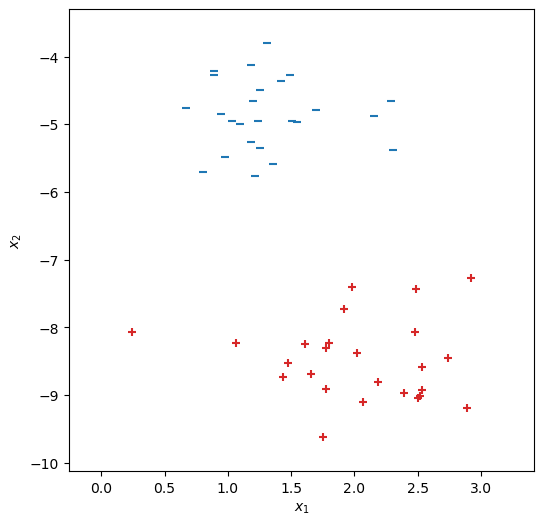

In [10]:
from sklearn.datasets import make_blobs
D = make_blobs(n_samples=50, centers=2, random_state=129, cluster_std=.6)

fig, ax = init_graph(D[0])
plot_data(ax, D[0], D[1])
plt.show()

訓練データをNumPyのオブジェクトからPyTorchのオブジェクトに変換しておく。訓練データは$50 \times 2$の行列`X`、$50 \times 1$の行列`Y`で表される。

In [11]:
from torch.utils.data import TensorDataset, DataLoader

dtype = torch.float
X = torch.from_numpy(D[0]).type(dtype)
Y = torch.from_numpy(D[1].reshape(-1, 1)).type(dtype)

In [12]:
X[:4]

tensor([[ 2.4885, -7.4323],
        [ 1.4338, -8.7279],
        [ 2.1874, -8.8029],
        [ 1.1995, -4.6490]])

In [13]:
Y[:4]

tensor([[1.],
        [1.],
        [1.],
        [0.]])

以降では、$2$次元の入力$\pmb{x} \in \mathbb{R}^2$を受け取り、$1$次元の値$\hat{y}$を出力する1層のニューラルネットワーク（パラメータ$\pmb{w} \in \mathbb{R}^{2}$と$b \in \mathbb{R}$）

<a id="f8-7"></a>
(8.7)  
$$
\begin{align}
\hat{y} = \sigma(\pmb{x} \cdot \pmb{w} + b)
\end{align}
$$

を学習するプログラムの実装例を複数紹介する。

### 原始的な実装

In [14]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Parameters of the single-layer neural network.
w = torch.randn(2, 1, dtype=dtype, requires_grad=True)
b = torch.randn(1, dtype=dtype, requires_grad=True)

H = []
eta = 0.01
for t in range(1000):
    sumloss = 0.
    for x, y in loader:
        y_hat = (x.matmul(w) + b).sigmoid()
        l = y * y_hat + (1 - y) * (1 - y_hat)
        loss = -l.log().sum()
        sumloss += loss.item()

        loss.backward()
        with torch.no_grad():
            w -= eta * w.grad
            b -= eta * b.grad
            w.grad.zero_()
            b.grad.zero_()
            
    H.append(sumloss)

以下では、このプログラムにおいて重要な箇所を解説する。

```python
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

for x, y in loader:
    # Do something for x and y.
```

上のコードは、訓練データ（`X`と`y`）の順番をランダムにシャッフルしたうえで、4事例からなるミニバッチ（`x`と`y`）に対する処理を繰り返すものである。`x`と`y`はそれぞれ、$4 \times 2$、$4 \times 1$の行列である。

```python
w = torch.randn(2, 1, dtype=dtype, requires_grad=True)
b = torch.randn(1, dtype=dtype, requires_grad=True)
```

単層ニューラルネットワーク・モデルのパラメータとして、$2 \times 1$の行列`w`と、スカラー`b`を定義する。


```python
y_hat = (x.matmul(w) + b).sigmoid()
```

ミニバッチ処理のため、式[(8.7)](#f8-7)の $\pmb{x}$ を縦に4個積んだ行列$\pmb{X}$を用い、$\hat{y}$を縦に4個積んだ行列$\hat{\pmb{y}}$を計算する。[ブロードキャスト](https://pytorch.org/docs/stable/notes/broadcasting.html)により、スカラである`b`はベクトルに拡張され、計算が行われる。

<a id="f8-8"></a>
(8.8)  

\begin{align}
\hat{\pmb{y}} &= \sigma(\pmb{X}\pmb{w} + \pmb{b}) \\
\begin{pmatrix}
\hat{y}_1 \\
\hat{y}_2 \\
\hat{y}_3 \\
\hat{y}_4
\end{pmatrix}
&= \sigma\left(
\begin{pmatrix}
X_{1,1} & X_{1,2} \\
X_{2,1} & X_{2,2} \\
X_{3,1} & X_{3,2} \\
X_{4,1} & X_{4,2}
\end{pmatrix}
\begin{pmatrix}
w_1 \\ w_2
\end{pmatrix}
+
\begin{pmatrix}
b \\
b \\
b \\
b
\end{pmatrix}
\right)
\end{align}

```python
l = y * y_hat + (1 - y) * (1 - y_hat)
```

事例ごとに尤度を計算して、`l`に格納する。

<a id="f8-9"></a>
(8.9)  
\begin{align}
\pmb{l} &= \pmb{y} \odot \hat{\pmb{y}} + (1 - \pmb{y}) \cdot (1 - \hat{\pmb{y}}) \\
\begin{pmatrix}
l_1 \\
l_2 \\
l_3 \\
l_4
\end{pmatrix}
&=
\begin{pmatrix}
y_1 \hat{y}_1 \\
y_2 \hat{y}_2 \\
y_3 \hat{y}_3 \\
y_4 \hat{y}_4
\end{pmatrix}
+
\begin{pmatrix}
(1 - y_1) (1 - \hat{y}_1) \\
(1 - y_2) (1 - \hat{y}_2) \\
(1 - y_3) (1 - \hat{y}_3) \\
(1 - y_4) (1 - \hat{y}_4)
\end{pmatrix}
\end{align}


```python
loss = -l.log().sum()
```

損失値$-\sum_{i=1}^4 \log l_i$を計算する。

```python
loss.backward()
```

損失値に対する各変数の勾配を自動微分で計算する。

```python
with torch.no_grad():
   # Do something with computed gradients (disable gradient calculation).
```

`with`以下のブロックの処理を自動微分の対象から外す。ゆくゆくは、勾配に基づいて`w`や`b`を更新することになるが、`w`や`b`は自動微分の対象となる関数を構成する変数であるため、その値を更新してしまうと自動微分の結果も変わってしまう。そこで、以降の処理は自動微分の計算の対象外としておき、`w`や`b`の値を更新できるようにする。

```python
w -= eta * w.grad
b -= eta * b.grad
```

確率的勾配降下法の更新式に基づき、パラメータ`w`と`b`の値を更新する。

```python
w.grad.zero_()
b.grad.zero_()
```

パラメータ`w`と`b`の勾配を$0$にリセットする。これを実行しておかないと、backwardメソッドを次に呼び出したときに、これまでに計算された勾配の値を引き継いで（加算されて）しまう。

プログラムの解説はここまでとする。損失値の推移をプロットする。

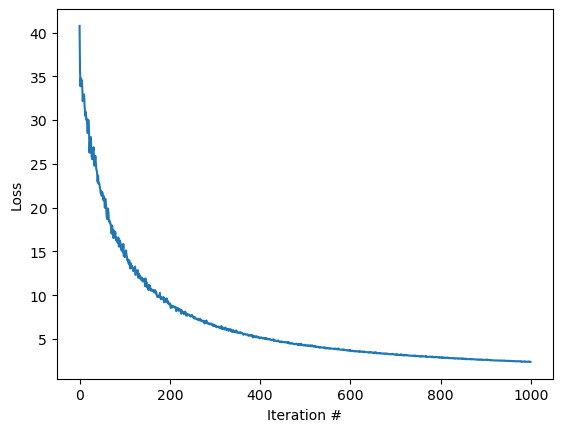

In [15]:
fig, ax = plt.subplots()
ax.plot(H)
ax.set_xlabel('Iteration #')
ax.set_ylabel('Loss')
plt.show()

学習で求められたパラメータの値を確認する。

In [16]:
w, b

(tensor([[ 0.2995],
         [-1.9079]], requires_grad=True),
 tensor([-12.9546], requires_grad=True))

$\pmb{x} \cdot \pmb{w} + b$の値とともに、訓練データを描画する。正例と負例を正しく分類できることが分かる。

/tmp/ipykernel_376/3915955710.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660136134696/work/torch/csrc/utils/tensor_new.cpp:201.)
  ax.scatter(X[I,0], X[I,1], c='tab:blue', marker='_')


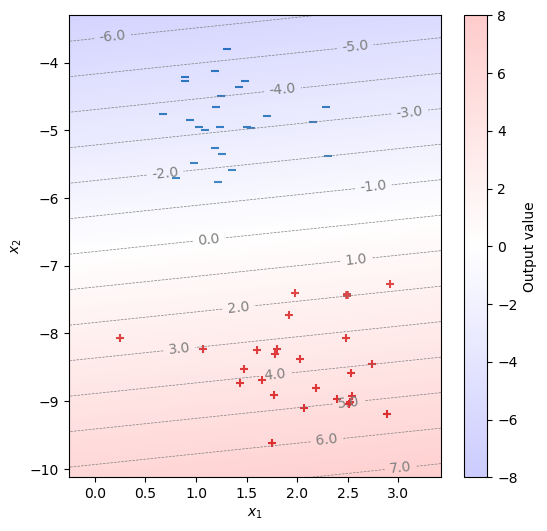

In [17]:
def model(x):
    return x.matmul(w) + b

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

### Sequentialによる実装

以下は[torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)を用いて、単層のニューラルネットワークを実装する例である。「2次元から1次元への線形変換（バイアス項あり）」といったレベルの記述だけで、ニューラルネットワークのパラメータが定義され、入力に対応した出力の値を計算できる。さらに、二値クロスエントロピー損失関数を自前で実装せずに、[torch.nn.BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)を用いる。

In [18]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Single-layer NN: 2 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True),
)
loss_fn = torch.nn.BCEWithLogitsLoss()

eta = 0.1
for t in range(1000):
    for x, y in loader:
        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            for param in model.parameters():
                param -= eta * param.grad

定義されたニューラルネットワークのモデルを表示する。

In [19]:
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

学習で求められたパラメータの値を確認する。

In [20]:
model.state_dict()

OrderedDict([('0.weight', tensor([[ 0.5633, -2.5414]])),
             ('0.bias', tensor([-17.4594]))])

$\hat{y}$の値とともに、訓練データを描画する。

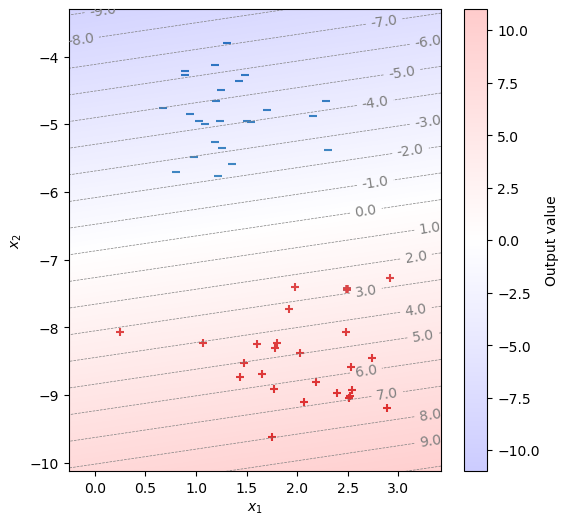

In [21]:
fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

### 最適化アルゴリズムの利用

さらに、確率的勾配降下法を自前で実装せずに、[torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)を利用する実装例である。プログラムがかなりシンプルになった。

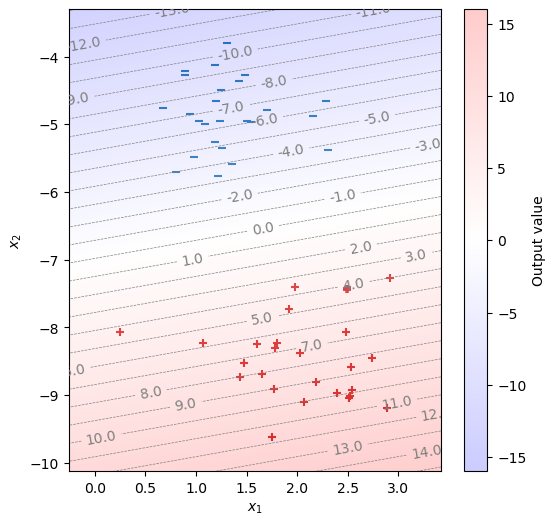

In [22]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Single-layer NN: 2 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True),
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
    for x, y in loader:
        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

### NNのクラスを定義・実装する

[torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)クラスを継承してニューラルネットワークのクラスを自前で定義する例である。入力から出力を計算する処理をforwardメソッドに実装する。Sequentialでは定義できないような複雑なニューラルネットワークを実装できる。

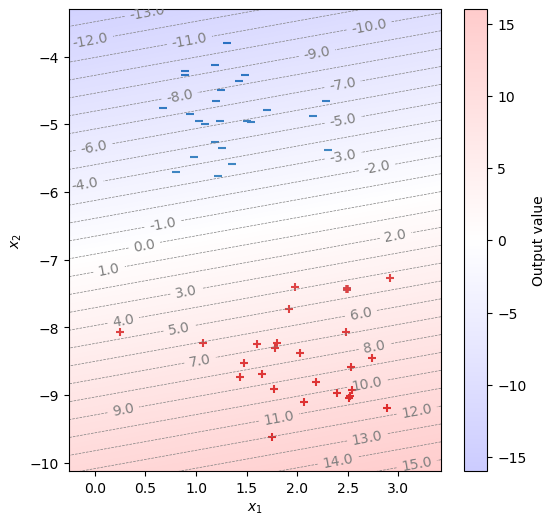

In [23]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Define a neural network as a class.
class SingleLayerNN(torch.nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.linear1 = torch.nn.Linear(d_in, d_out, bias=True)

    def forward(self, x):
        return self.linear1(x)

model = SingleLayerNN(2, 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
    for x, y in loader:
        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

学習で求められたパラメータを確認する。

In [24]:
model.state_dict()

OrderedDict([('linear1.weight', tensor([[ 1.0219, -3.7887]])),
             ('linear1.bias', tensor([-26.2047]))])

## 多層NNの実装

事例数$N=100$、入力$\pmb{x}$の次元数$d_{\rm in}=2$の二値分類の訓練データを用意する（このデータは線形分離不能である）。

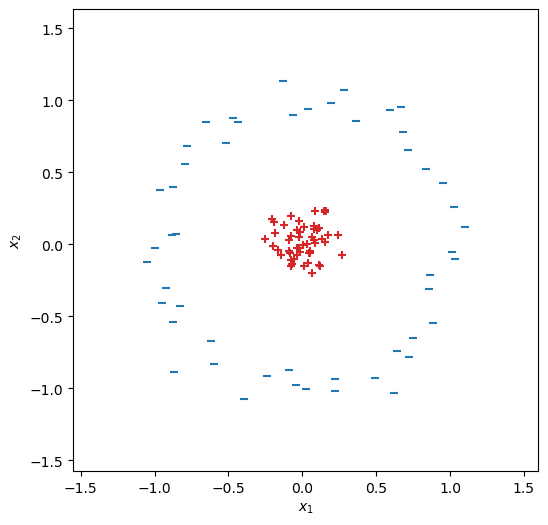

In [25]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_circles

D = make_circles(100, factor=.1, noise=.1, random_state=9)

dtype = torch.float
X = torch.from_numpy(D[0]).type(dtype)
Y = torch.from_numpy(D[1].reshape(-1, 1)).type(dtype)

fig, ax = init_graph(X)
plot_data(ax, X, Y)
plt.show()

### 単層NN

手始めに、Sequentialで単層のニューラルネットワークを学習してみる。正例と負例を分離できる平面を引くことができない。

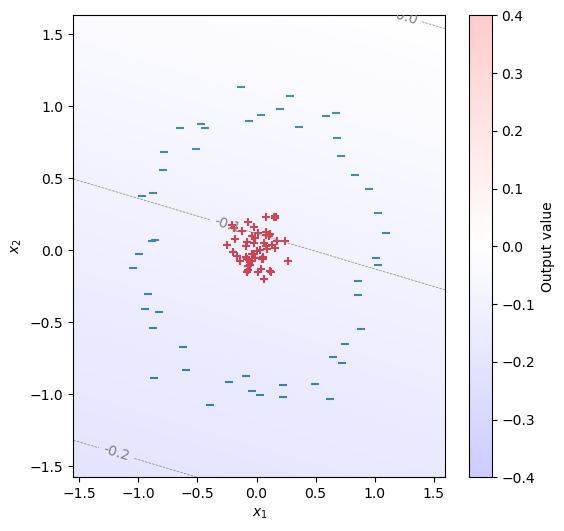

In [26]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Single-layer NN: 2 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True),
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
    for x, y in loader:
        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model, 0.1)
plt.show()

### 多層NN

中間層のユニット数を$4$とした2層のニューラルネットワークをSequentialで定義する。先ほどの実装から変更すべき箇所は、以下の部分だけである。
```
    torch.nn.Linear(2, 4, bias=True),
    torch.nn.Sigmoid(),
    torch.nn.Linear(4, 1, bias=True),
```

$\hat{y}$を描画してみると、学習されたモデルが非線形な分類を行うことが確認できる。

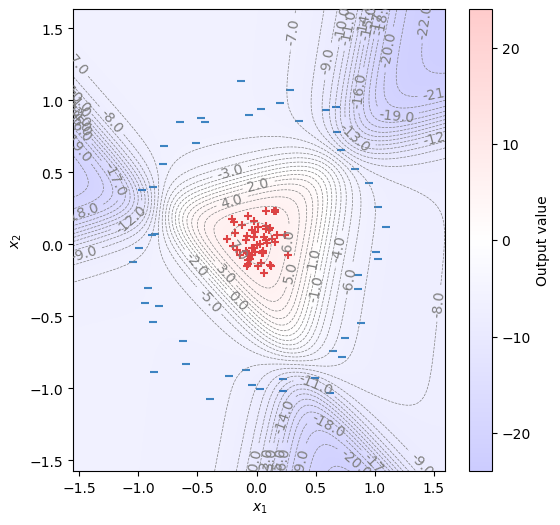

In [27]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Two-layer NN: 2 -> 4 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(2, 4, bias=True),
    torch.nn.Sigmoid(),
    torch.nn.Linear(4, 1, bias=True),
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
    for x, y in loader:
        y_hat = model(x)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

## 確認問題: 自動微分

2次元の入力$\pmb{x} \in \mathbb{R}^{2}$を受け取り、2次元の中間層$\pmb{h} \in \mathbb{R}^{2}$を介して、$\hat{y} \in \mathbb{R}$を出力する2層のニューラルネットワークを次式で定義する。
\begin{align*}
\hat{y} = \sigma(\pmb{h}^{\top}\pmb{q}+c), \; \pmb{h}=\mathrm{ReLU}(\pmb{W}\pmb{x} + \pmb{b})
\end{align*}
ただし、$\sigma(.)$はシグモイド関数であり、$\mathrm{ReLU}(a) = \max(a, 0)$である。また、$\pmb{W} \in \mathbb{R}^{2 \times 2}, \pmb{q} \in \mathbb{R}^{2}, b \in \mathbb{R}^2, c \in \mathbb{R}$はモデルのパラメータであり、以下に示す値に設定されているとする。
\begin{align*}
\pmb{W} = \begin{pmatrix}1 & 1 \\ -1 & -1\end{pmatrix}, \; \pmb{q} = \begin{pmatrix}1 \\ 1\end{pmatrix}, \; \pmb{b} = \begin{pmatrix}-0.5 \\ 1.5\end{pmatrix}, \; c = -1.5
\end{align*}

**(1) 出力の計算**

このモデルに入力$\pmb{x}=\begin{pmatrix}0 \\ 0\end{pmatrix}$が与えられたとき、中間層の値$\pmb{h}$と出力値$\hat{y}$を求めよ。

In [28]:
import numpy as np
import torch


dtype = torch.float

# Variables
W = torch.tensor(np.array([[1, 1], [-1, 1]]), requires_grad=True, dtype=dtype)
b = torch.tensor(np.array([-0.5, 1.5]), requires_grad=True, dtype=dtype)
q = torch.tensor(np.array([1, 1]), requires_grad=True, dtype=dtype)
c = torch.tensor(np.array([-1.5]), requires_grad=True, dtype=dtype)

x = torch.from_numpy(np.zeros(2)).type(dtype)

# Forward
hidden = (x @ W + b).relu()
output = (hidden @ q + c).sigmoid()

print(f"hidden = {hidden}")
print(f"output = {output}")

hidden = tensor([0.0000, 1.5000], grad_fn=<ReluBackward0>)
output = tensor([0.5000], grad_fn=<SigmoidBackward0>)


**(2) 勾配の計算**

ある学習事例$(\pmb{x}, y) = \left(\begin{pmatrix}1 \\ 1 \end{pmatrix}, 0\right)$に対して、このニューラルネットワークをクロスエントロピー損失関数の値、および損失関数の$\pmb{W}$, $\pmb{q}$, $\pmb{b}$, $c$に関する勾配の値を求めよ。

In [29]:
loss = - torch.log((torch.ones(1) - output))
print(f"loss={loss}")

loss=tensor([0.6931], grad_fn=<NegBackward0>)


In [30]:
loss.backward()
print(f"gradient W: {W.grad}")
print(f"gradient b: {b.grad}")
print(f"gradient q: {q.grad}")
print(f"gradient c: {c.grad}")

gradient W: tensor([[0., 0.],
        [0., 0.]])
gradient b: tensor([0.0000, 0.5000])
gradient q: tensor([0.0000, 0.7500])
gradient c: tensor([0.5000])


## 確認問題: NNの学習

深層学習フレームワークを用いて、手書き数字認識を行うニューラルネットワークを学習したい。

**(1) モデルの学習**

MNISTの訓練データを用いて単層のニューラルネットワークを学習せよ。このとき、各エポック毎に以下の評価値を計算し、グラフとして表示せよ。

+ 訓練データ上の損失関数の値
+ 訓練データ上の正解率
+ 評価データ上の損失関数の値
+ 評価データ上の正解率

MNISTデータ準備：02multi.ipynb で使用したコードを再掲  

In [31]:
import gzip
import sys
import struct
import urllib.request
from pathlib import Path
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

def save_mnist():
    if Path("mnist/mnist.npz").exists():
        return
    np.savez_compressed(
        "mnist",
        train_x=read_image(openurl_gzip("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")),
        train_y=read_label(openurl_gzip("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")),
        test_x=read_image(openurl_gzip("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")),
        test_y=read_label(openurl_gzip("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"))
    )

save_mnist()
data = np.load("mnist/mnist.npz")
print("Training data (X):", data["train_x"].shape, data["train_x"].dtype)
print("Training data (Y):", data["train_y"].shape, data["train_y"].dtype)
print("Test data (X):", data["test_x"].shape, data["test_x"].dtype)
print("Test data (Y):", data["test_y"].shape, data["test_y"].dtype)

Training data (X): (60000, 28, 28) float32
Training data (Y): (60000,) uint8
Test data (X): (10000, 28, 28) float32
Test data (Y): (10000,) uint8


In [32]:
num_category = 10

In [33]:
X_train = data["train_x"].reshape((data["train_x"].shape[0], -1))
Y_train = np.zeros((data["train_y"].shape[0], num_category))
Y_train[np.arange(len(data["train_y"])), data["train_y"]] = 1.0
print(X_train.shape)
print(Y_train.shape)

(60000, 784)
(60000, 10)


In [34]:
X_test = data["test_x"].reshape((data["test_x"].shape[0], -1))
Y_test = np.zeros((data["test_y"].shape[0], num_category))
Y_test[np.arange(len(data["test_y"])), data["test_y"]] = 1.0
print(X_test.shape)
print(Y_test.shape)

(10000, 784)
(10000, 10)


In [35]:
from torch.utils.data import TensorDataset


train_data = TensorDataset(
    torch.from_numpy(X_train).type(dtype),
    torch.from_numpy(Y_train).type(dtype)
)
test_data = TensorDataset(
    torch.from_numpy(X_test).type(dtype),
    torch.from_numpy(Y_test).type(dtype)
)

モデルの学習

In [36]:
from torch.utils.data import DataLoader


model = torch.nn.Sequential(
    torch.nn.Linear(28 * 28, 10),
    torch.nn.Softmax(dim=1)
)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loader = DataLoader(train_data, batch_size=32, shuffle=True)

history = []
for t in range(30):
    sum_loss = 0
    for x, y in loader:
        loss = loss_function(y, model(x))
        sum_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    history.append(sum_loss)

<AxesSubplot:title={'center':'loss per epoch'}>

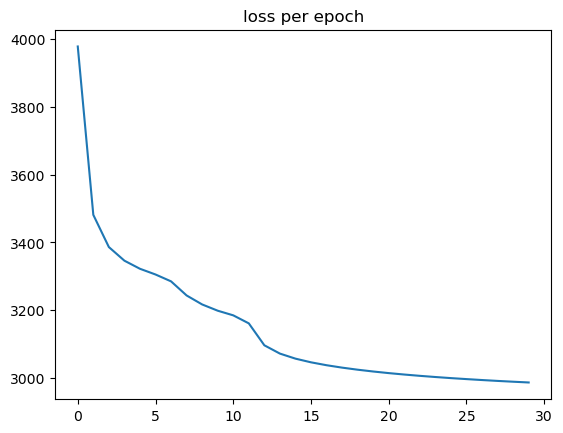

In [37]:
import pandas as pd


pd.Series(history).plot.line(title="loss per epoch")

**(2) 適合率、再現率、F1スコア**

(1)で学習したモデルに対して、評価データ上で以下の評価値を計算せよ。

+ 各カテゴリ（数字）に対する適合率、再現率、F1スコア
+ 各カテゴリの適合率、再現率、F1スコアのマクロ平均を取ったもの

In [38]:
from sklearn.metrics import classification_report


y_hat = None
with torch.inference_mode():
    y_proba = model(torch.from_numpy(X_test).type(dtype)).numpy()
    y_hat = np.argmax(y_proba, axis=1)
    y_max_proba = np.amax(y_proba, axis=1)

print(classification_report(data["test_y"], y_hat))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       980
           1       0.96      0.97      0.96      1135
           2       0.92      0.87      0.90      1032
           3       0.90      0.89      0.90      1010
           4       0.88      0.93      0.91       982
           5       0.90      0.81      0.85       892
           6       0.92      0.94      0.93       958
           7       0.91      0.91      0.91      1028
           8       0.86      0.88      0.87       974
           9       0.90      0.87      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



**(3) 混同行列**

(1)で学習したモデルに対して、評価データ上で混同行列を計算せよ。

上記参照

**(4) 紛らわしい事例**

(1)で学習したモデルにとって認識が簡単な評価事例トップ3と、難しい評価事例トップ3を求めたい。ある事例$x_i$に対して、正解のカテゴリを$y_i$、モデルが予測したカテゴリを$\hat{y}_i$とする。モデルが認識に成功した（つまり$\hat{y}_i = y_i$となる）事例に対して、認識の簡単さを条件付き確率$p(\hat{y} | x)$で定義する。一方で、モデルが認識に失敗した（つまり$\hat{y}_i \neq y_i$となる）事例に対しても、認識の難しさを条件付き確率$p(\hat{y} | x)$で定義する。

このようにして見つけた6件の評価事例のそれぞれに対して、$y_i$, $p(y_i | x_i)$, $\hat{y}_i$, $p(\hat{y}_i | x_i)$とその事例の画像を表示せよ。

In [39]:
import matplotlib.pyplot as plt


def mnist_plot(x, y, y_hat):
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    ax.set_title(f"Gold label: {y}, Predicted: {y_hat}")
    im = ax.imshow(x)
    fig.colorbar(im)
    plt.show()

In [40]:
predictions_df = pd.DataFrame({
    "y": data["test_y"],
    "y_hat": y_hat,
    "y_proba": y_max_proba
})

correct_df = predictions_df[(predictions_df["y"] == predictions_df["y_hat"])]
correct_df.nlargest(3, "y_proba")

,y,y_hat,y_proba
1341,2,2,1.0
3668,2,2,1.0
5436,2,2,1.0


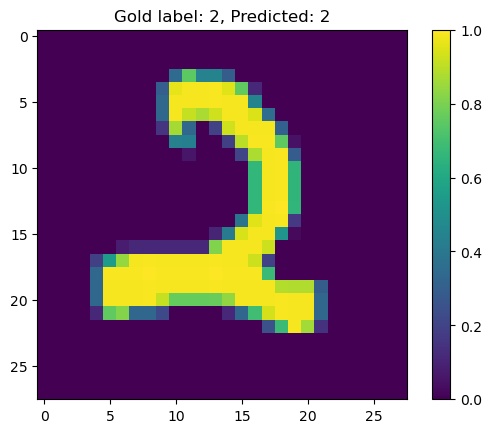

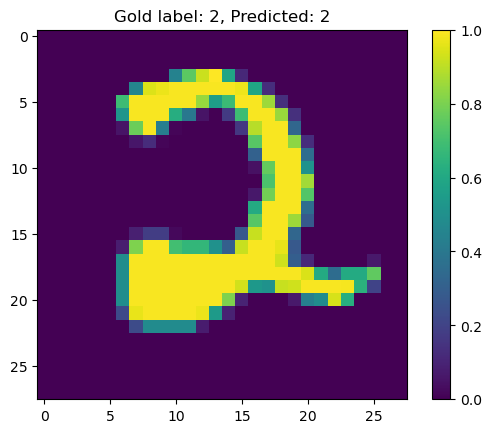

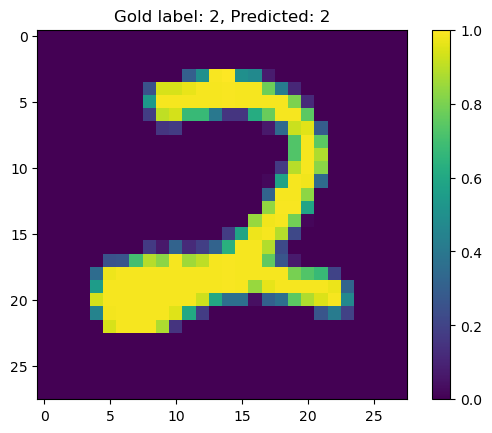

In [41]:
for i in correct_df.nlargest(3, "y_proba").index:
    mnist_plot(data["test_x"][i].reshape((28, 28)), predictions_df["y"][i], predictions_df["y_hat"][i])

In [42]:
different_df = predictions_df[(predictions_df["y"] != predictions_df["y_hat"])]
different_df.nsmallest(3, "y_proba")

,y,y_hat,y_proba
7195,5,7,0.174357
4248,2,4,0.234153
7531,5,8,0.272320


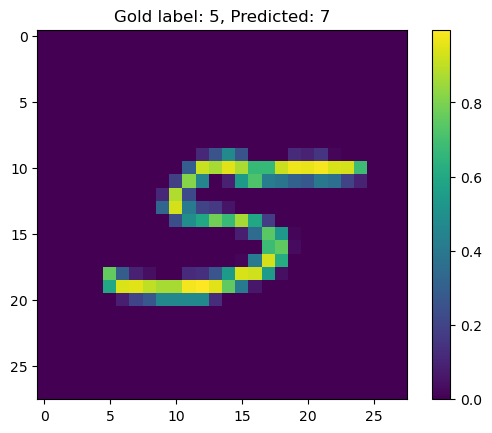

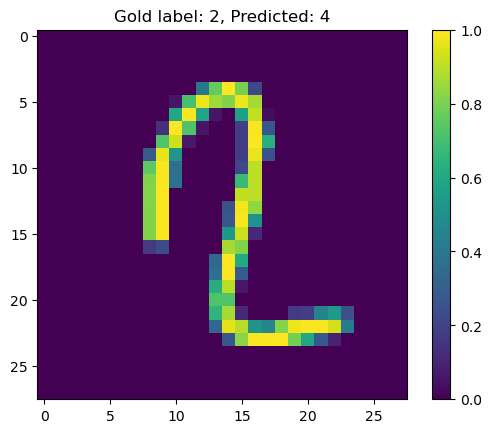

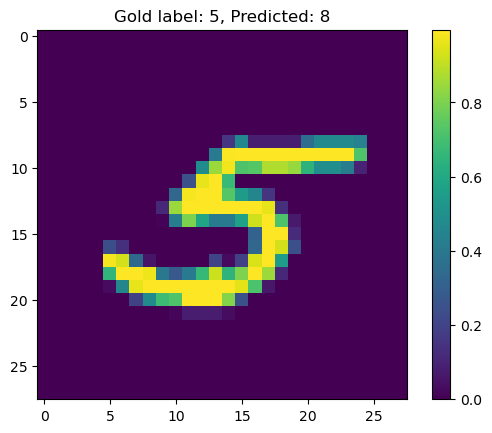

In [43]:
for i in different_df.nsmallest(3, "y_proba").index:
    mnist_plot(data["test_x"][i].reshape((28, 28)), predictions_df["y"][i], predictions_df["y_hat"][i])

**(5) 多層ニューラルネットワーク**

多層ニューラルネットワークを適当に構成し、(1)の実験を再度実行せよ。どのようなネットワーク構成にするかは任意である。

In [44]:
model_mlp = torch.nn.Sequential(
    torch.nn.Linear(28 * 28, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),
    torch.nn.Softmax(dim=1)
)


optimizer_mlp = torch.optim.SGD(model_mlp.parameters(), lr=0.01)

history = []
for t in range(30):
    sum_loss = 0
    for x, y in loader:
        loss = loss_function(y, model_mlp(x))
        sum_loss += loss.item()
        optimizer_mlp.zero_grad()
        loss.backward()
        optimizer_mlp.step()
    
    history.append(sum_loss)

<AxesSubplot:title={'center':'loss per epoch'}>

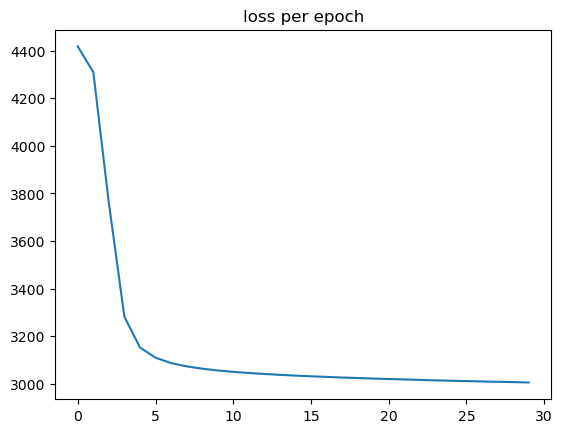

In [45]:
pd.Series(history).plot.line(title="loss per epoch")

In [46]:
from sklearn.metrics import classification_report


y_hat = None
with torch.inference_mode():
    y_proba = model_mlp(torch.from_numpy(X_test).type(dtype)).numpy()
    y_hat = np.argmax(y_proba, axis=1)
    y_max_proba = np.amax(y_proba, axis=1)

print(classification_report(data["test_y"], y_hat))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       980
           1       0.98      0.98      0.98      1135
           2       0.91      0.93      0.92      1032
           3       0.70      0.94      0.81      1010
           4       0.88      0.96      0.92       982
           5       0.00      0.00      0.00       892
           6       0.91      0.96      0.94       958
           7       0.91      0.94      0.93      1028
           8       0.70      0.92      0.80       974
           9       0.94      0.91      0.92      1009

    accuracy                           0.86     10000
   macro avg       0.78      0.85      0.81     10000
weighted avg       0.80      0.86      0.83     10000



/home/studio-lab-user/.conda/envs/mlnote/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studio-lab-user/.conda/envs/mlnote/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studio-lab-user/.conda/envs/mlnote/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

---

[機械学習帳](https://chokkan.github.io/mlnote/) © Copyright 2020-2022 by [岡崎 直観 (Naoaki Okazaki)](https://www.chokkan.org/). この作品は<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">クリエイティブ・コモンズ 表示 - 非営利 - 改変禁止 4.0 国際 ライセンス</a>の下に提供されています。 <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="クリエイティブ・コモンズ・ライセンス" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/80x15.png" /></a>　ただし、作品中のコードセル部分は<a rel="license" href="https://opensource.org/licenses/MIT">MITライセンス</a>の下に提供されています。